<a href="https://colab.research.google.com/github/carlosdgerez/machine_learning/blob/main/module7/music1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2021 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Setup

This tutorial uses the [`pretty_midi`](https://github.com/craffel/pretty-midi) library to create and parse MIDI files, and [`pyfluidsynth`](https://github.com/nwhitehead/pyfluidsynth) for generating audio playback in Colab.

In [1]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 49 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1 [20.7 kB]
Get:4 http://archi

In [2]:
!pip install --upgrade pyfluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 27.3 MB/s 
     |████████████████████████████████| 51 kB 7.6 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=0111ff1e3dc4c9a0d6b047395de356b3f233e05e9034671d2ade8f2a5d353057
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


In [4]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [5]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## Download the Maestro dataset

In [6]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59252736/59243107 [==============================] - 0s 0us/step


In [ ]:
data_dir = pathlib.Path('data/maestro-v3.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v3.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

58425344/58416533 [==============================] - 1s 0us/step


In [ ]:
# download the groove drums dataset
data_dir = pathlib.Path('data/groove')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'groove-v1.0.0.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/groove/groove-v1.0.0.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

5111611392/5111599714 [==============================] - 105s 0us/step


In [ ]:
#selection of the data to process
filenames = glob.glob(str(data_dir/'drummer**/session*/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1110


In [7]:
# data dir makes easier to change from dataset to dataset thar are downloaded 
data_dir= pathlib.Path('data/maestro-v2.0.0')

In [8]:
# select data to process In this case just music pertained to Schubert
filenames = glob.glob(str(data_dir/'*2018*/MIDI-Unprocessed_Schubert*.mid*'))
print('Number of files:', len(filenames))

Number of files: 12


In [9]:
# select data to process In this case just music pertained to Schubert
filenames = glob.glob(str(data_dir/'*2018*/MIDI*.mid*'))
print('Number of files:', len(filenames))

Number of files: 99


## Process a MIDI file

First, use ```pretty_midi``` to parse a single MIDI file and inspect the format of the notes. If you would like to download the MIDI file below to play on your computer, you can do so in colab by writing ```files.download(sample_file)```.


In [30]:
sample_file = filenames[2]
print(sample_file)

data/maestro-v2.0.0/2018/MIDI-Unprocessed_Recital20_MID--AUDIO_20_R1_2018_wav--3.midi


Generate a `PrettyMIDI` object for the sample MIDI file.

In [31]:
pm = pretty_midi.PrettyMIDI(sample_file)

Play the sample file. The playback widget may take several seconds to load.

In [32]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [33]:
display_audio(pm)

Do some inspection on the MIDI file. What kinds of instruments are used?

In [34]:
print('Number of instruments:', len(pm.instruments))
#inst = pretty_midi.Instrument(program=0, is_drum=True)
#pm.instruments.append(inst)
instrument = pm.instruments[0]

instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


## Extract notes

In [35]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=65, note_name=F4, duration=0.2422
1: pitch=63, note_name=D#4, duration=0.2044
2: pitch=61, note_name=C#4, duration=0.1992
3: pitch=59, note_name=B3, duration=0.1706
4: pitch=61, note_name=C#4, duration=0.0924
5: pitch=63, note_name=D#4, duration=0.1602
6: pitch=65, note_name=F4, duration=0.0977
7: pitch=67, note_name=G4, duration=4.8359
8: pitch=65, note_name=F4, duration=0.2917
9: pitch=63, note_name=D#4, duration=0.1771


We will use three variables to represent a note when training the model: `pitch`, `step` and `duration`. The pitch is the perceptual quality of the sound as a MIDI note number. 
The `step` is the time elapsed from the previous note or start of the track.
The `duration` is how long the note will be playing in seconds and is the difference between the note end and note start times. 


Extract the notes from the sample MIDI file.

In [36]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [37]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,67,0.158854,4.994792,0.000000,4.835937
1,65,1.002604,1.244792,0.843750,0.242188
2,63,1.647135,1.851562,0.644531,0.204427
3,61,2.291667,2.490885,0.644531,0.199219
4,59,2.897135,3.067708,0.605469,0.170573


It may be easier to interpret the note names rather than the pitches, so we can use the function below to convert from the numeric pitch values to note names. 
The note name shows the type of note, accidental and octave number
(e.g. C#4). 

In [38]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['G4', 'F4', 'D#4', 'C#4', 'B3', 'C#4', 'D#4', 'F4', 'G4', 'F4'],
      dtype='<U3')

To visualize the musical piece, plot the note pitch, start and end across the length of the track (i.e. piano roll). Start with the first 100 notes

In [39]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

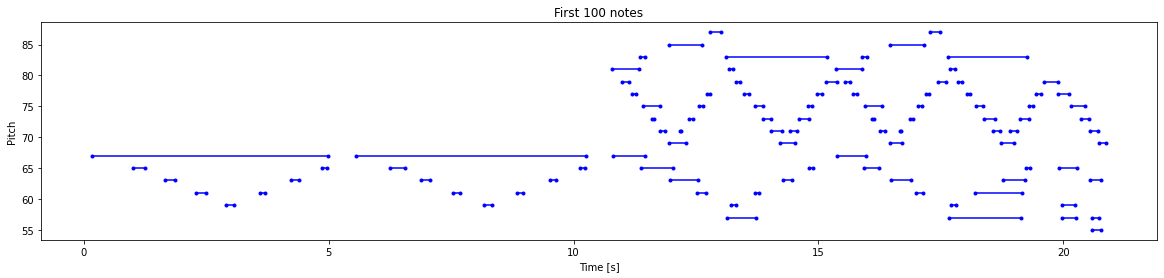

In [40]:
plot_piano_roll(raw_notes, count=100)

Plot the notes for the entire track.

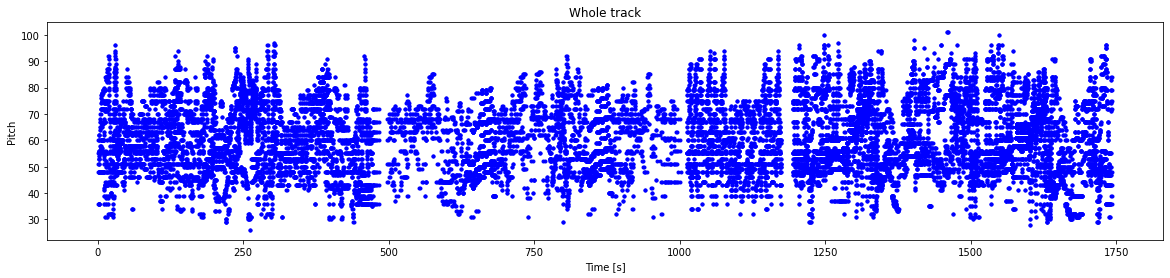

In [ ]:
plot_piano_roll(raw_notes)

Check the distribution of each note variable.

In [41]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

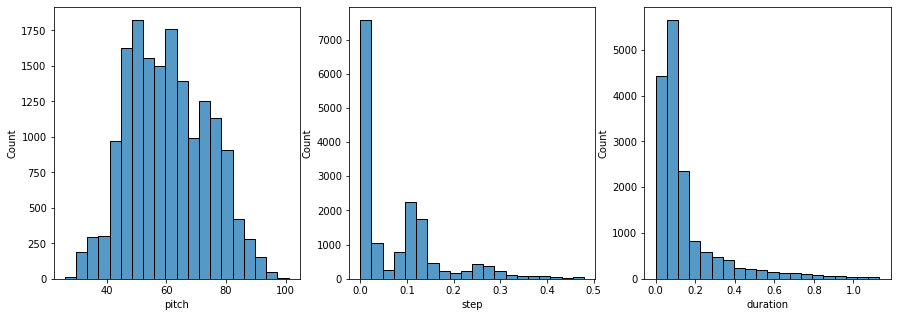

In [ ]:
plot_distributions(raw_notes)

## Create a MIDI file

You can generate your own MIDI file from a list of notes using the function below.

In [42]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [43]:
example_file = 'example2.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

Play the generated MIDI file and see if there is any difference.

In [44]:
display_audio(example_pm)

In [45]:
# download the midi file to my computer 
from google.colab import files
files.download('example2.midi')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

As before, you can write ```files.download(example_file)``` to download and play this file.

## Create the training dataset


Create the training dataset by extracting notes from the MIDI files. I used 12 files from Schubert 2018 concerts.  This may take a couple minutes.

In [48]:
num_files = 40
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [49]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 383081


Next, create a `tf.data.Dataset` from the parsed notes.

In [50]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [51]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

We will train the model on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and the next note as the label. In this way, the model will be trained to predict the next note in a sequence. You can find a diagram describing this process (and more details) in [Text classification with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

You can use the handy [window](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) function with size `seq_length` to create the features and labels in this format.

In [52]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

Set the sequence length for each example. Experiment with different lengths (e.g. 50, 100, 150) to see which one works best for the data, or use [hyperparameter tuning](https://www.tensorflow.org/tutorials/keras/keras_tuner). The size of the vocabulary (`vocab_size`) is set to 128 representing all the pitches supported by `pretty_midi`.

In [53]:
seq_length = 200
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(200, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [54]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (200, 3)
sequence elements (first 10): tf.Tensor(
[[4.68750000e-01 0.00000000e+00 1.08463542e+00]
 [3.98437500e-01 6.51041667e-03 1.07031250e+00]
 [2.81250000e-01 1.30208333e-03 1.05989583e+00]
 [3.75000000e-01 1.30208333e-03 1.05859375e+00]
 [4.29687500e-01 7.81250000e-03 1.07942708e+00]
 [4.68750000e-01 1.37760417e+00 1.66666667e-01]
 [3.98437500e-01 9.11458333e-03 3.12500000e-02]
 [3.75000000e-01 0.00000000e+00 4.81770833e-02]
 [2.81250000e-01 1.17187500e-02 4.42708333e-02]
 [4.37500000e-01 7.81250000e-02 1.54947917e-01]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=60.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.07161458333333215>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.06510416666666785>}


Batch the examples, and configure the dataset for performance.

In [55]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [56]:
train_ds.element_spec

(TensorSpec(shape=(64, 200, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Create and train the model

The model will have three outputs, one for each note variable. For `step` and `duration`, we will have a custom loss function based on mean squared error that encourages the model to output non-negative values.

In [57]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [77]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)


#x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.Dropout(0.2)(x)


outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 200, 3)]     0           []                               
                                                                                                  
 lstm_12 (LSTM)                 (None, 128)          67584       ['input_16[0][0]']               
                                                                                                  
 dropout_11 (Dropout)           (None, 128)          0           ['lstm_12[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['dropout_11[0][0]']             
                                                                                           

Testing the `model.evaluate` function, you can see that the `pitch` loss is significantly greater than the `step` and `duration` losses. 
Note that `loss` is the total loss computed by summing all the other losses and is currently dominated by the `pitch` loss.

In [62]:
losses = model.evaluate(train_ds, return_dict=True)
losses

    346/Unknown - 398s 797ms/step - loss: 5.4284 - duration_loss: 0.2373 - pitch_loss: 4.8536 - step_loss: 0.3375

KeyboardInterrupt: ignored

One way balance this is to use the `loss_weights` argument to compile:

In [78]:

model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1,
        'duration':1.0,
    },
    optimizer=optimizer,
)

The `loss` then becomes the weighted sum of the individual losses.

In [79]:
model.evaluate(train_ds, return_dict=True)

5982/5982 [==============================] - 876s 116ms/step - loss: 1.5150 - duration_loss: 0.2539 - pitch_loss: 4.8526 - step_loss: 1.0186


{'duration_loss': 0.2538501024246216,
 'loss': 1.5150322914123535,
 'pitch_loss': 4.852595329284668,
 'step_loss': 1.0185520648956299}

Train the model.


# Add tensorboard to look at the process

In [80]:


# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime

# Clear any logs from previous runs
!rm -rf ./logs/

#create directory and callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [81]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 25

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/25
   2847/Unknown - 810s 284ms/step - loss: 0.4055 - duration_loss: 0.1251 - pitch_loss: 3.9880 - step_loss: 0.0810

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generate notes

To use the model to generate notes, you will first need to provide a starting sequence of notes. The function below generates one note from a sequence of notes. 

For note pitch, it draws a sample from the softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability.
Always picking the note with the highest probability would lead to repetitive sequences of notes being generated.

The `temperature` parameter can be used to control the randomness of notes generated. You can find more details on temperature in [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

In [ ]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

Now generate some notes. You can play around with temperature and the starting sequence in `next_notes` and see what happens.

In [ ]:
temperature = 1
num_predictions = 1000

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [ ]:
generated_notes.head(100)

,pitch,step,duration,start,end
0,45,0.080936,0.156597,0.080936,0.237533
1,124,0.187694,0.000000,0.268631,0.268631
2,27,0.221647,0.000000,0.490278,0.490278
3,21,0.573849,0.000000,1.064127,1.064127
4,21,0.505900,0.000000,1.570026,1.570026
...,...,...,...,...,...
95,98,0.247032,0.000000,36.147686,36.147686
96,17,0.237024,0.000000,36.384710,36.384710
97,107,0.627708,0.000000,37.012417,37.012417
98,124,0.251603,0.000000,37.264021,37.264021


In [ ]:
instrument_name = 'Taiko Drum'

In [ ]:
instrument_name = 'Pad 4 (choir)'

In [ ]:
instrument_name = 'Acoustic Grand Piano'

In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [ ]:
#save an example of produced music

from google.colab import files
files.download(out_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Visualize the generated notes.

In [ ]:
plot_piano_roll(generated_notes)

Check the distributions of `pitch`, `step` and `duration`.

In [ ]:
plot_distributions(generated_notes)

In the above plots, you will notice the change in distribution of the note variables.
Since there is a feedback loop between the model's outputs and inputs, the model tends to generate similar sequences of outputs to reduce the loss. 
This is particularly relevant for `step` and `duration`, which uses the MSE loss.
For `pitch`, you can increase the randomness by increasing the `temperature` in `predict_next_note`.


In [ ]:
# launch tensorboard in TensorBoard.dev (public for sharing the link)

!tensorboard dev upload \
  --logdir logs/fit \
  --name "(optional) My first convolutional" \
  --description "(optional) Simple comparison of several hyperparameters" \
  --one_shot